# Push Notificactions  
Predictive model: People interested in a product.  
Given a user and a product, predict if the wuold buy it if theywere buying at that moment.  
user with basket > 5 products
Linear model

## DataSet and functions

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = None
pd.options.display.max_rows = 10

### Functions

In [2]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"{model_name}: AUC:{pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(F"precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr,tpr,label=f"{model_name} - AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()

In [3]:
def Standardization(scaler,x_train):
    x_train_columns = x_train.columns
    x_train = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train, columns=x_train_columns)
    return x_train

### Load the data

In [5]:
#folder_path = Path("D:/Users/maick/Desktop/Codigos/zrive-ds/data/box_builder_dataset/feature_frame.csv")
folder_path = Path("C:/Users/AULA04/Desktop/Codes/zrive-ds/data/box_builder_dataset/feature_frame.csv")
feature_frame = pd.read_csv(folder_path)

## Preparation of the dataset

Filter for >5 products

In [6]:
size_of_order = feature_frame.groupby("order_id").outcome.sum()
size_of_order = size_of_order[size_of_order>=5]
feature_frame = feature_frame[feature_frame["order_id"].isin(size_of_order.index)]
feature_frame.shape[0]

2163953

Setting Dates cutoff

The 70% of orders were before the 2021-02-04
The 90% of orders were before the 2021-02-22


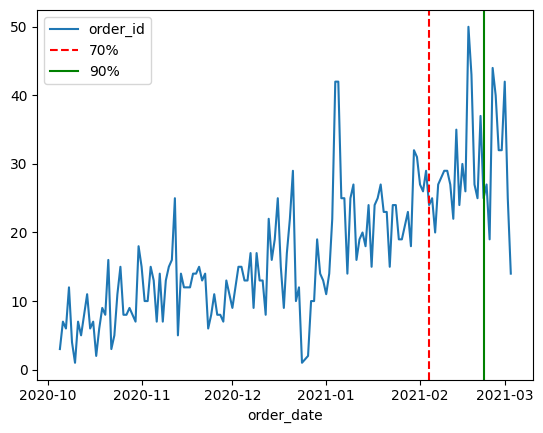

In [7]:
feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date

orders_diary = feature_frame.groupby("order_date").order_id.nunique()
porcentaje_orders_dairy = orders_diary.cumsum() / orders_diary.sum()

train_val_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.7].idxmax()
val_test_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.9].idxmax()

print(f"The 70% of orders were before the {train_val_cutoff}")
print(f"The 90% of orders were before the {val_test_cutoff}")
orders_diary.plot(kind="line")
plt.axvline(x=pd.to_datetime(train_val_cutoff), color='red', linestyle='--', label="70%")
plt.axvline(x=pd.to_datetime(val_test_cutoff), color='green', linestyle='-', label="90%")
plt.legend()

Sort the dataset

In [8]:
feature_frame = (feature_frame.sort_values("order_date",ascending=True).reset_index()).drop("index",axis = 1)

### Columns no numeric

Delete columns and Separate the data numeric

In [9]:
feature_frame = feature_frame.drop("variant_id",axis=1)
feature_frame = feature_frame.drop("user_id",axis=1)
feature_frame = feature_frame.drop("created_at",axis=1)
feature_frame = feature_frame.drop("order_id",axis=1)

column_numerics = []
for columns in feature_frame.dtypes:
    if columns == "int64" or columns == "float64":
        column_numerics.append(True)
    else:
        column_numerics.append(False)

feature_frame_numeric = feature_frame.loc[:, column_numerics]
feature_frame_numeric

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


## Divide the dataset

In [10]:
y = feature_frame_numeric["outcome"]
x = feature_frame_numeric.drop(columns=["outcome"])

### Temporarily

Temporarily, where the 70% goes until 2021-02-04 division for test and valid goes until 2021-02-22

In [11]:
x_train = x.iloc[:int(len(x)*0.7)]
x_test = x.iloc[int(len(x)*0.7):int(len(x)*0.9)]
x_valid = x.iloc[int(len(x)*0.9):]

y_train = y.iloc[:int(len(y)*0.7)]
y_test = y.iloc[int(len(y)*0.7):int(len(y)*0.9)]
y_valid = y.iloc[int(len(y)*0.9):]

print(f"Train: {len(x_train)} and {len(y_train)} ")
print(f"Valid: {len(x_valid)} and {len(y_valid)}")
print(f"Test: {len(x_test)} and {len(y_test)}") 

Train: 1514767 and 1514767 
Valid: 216396 and 216396
Test: 432790 and 432790


## Standardization

In [12]:
scaler = StandardScaler()
x_train = Standardization(scaler,x_train)

## Baseline

In [13]:
baseline_predictions = (feature_frame["global_popularity"] >= 0.5).astype(int)
print("Valitacion:\n", classification_report(feature_frame["outcome"], baseline_predictions))

Valitacion:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   2132624
         1.0       0.00      0.00      0.00     31329

    accuracy                           0.99   2163953
   macro avg       0.49      0.50      0.50   2163953
weighted avg       0.97      0.99      0.98   2163953



## LogisticRegression

In [14]:
xf = x[["ordered_before","global_popularity","abandoned_before"]]

x_train_f = xf.iloc[:int(len(xf)*0.7)]
x_test_f = xf.iloc[int(len(xf)*0.7):int(len(x)*0.9)]
x_valid_f = xf.iloc[int(len(xf)*0.9):]

y_train = y.iloc[:int(len(y)*0.7)]
y_test = y.iloc[int(len(y)*0.7):int(len(y)*0.9)]
y_valid = y.iloc[int(len(y)*0.9):]

print(f"Train: {len(x_train_f)} and {len(y_train)} ")
print(f"Valid: {len(x_valid_f)} and {len(y_valid)}")
print(f"Test: {len(x_test_f)} and {len(y_test)}")

x_train_f = Standardization(scaler,x_train_f)

#Rigde
LogReg_model_rigde_f = LogisticRegression(
    penalty="l2", 
    solver="liblinear",
    )

LogReg_model_rigde_f.fit(x_train_f, y_train)

y_train_LogReg_model_rigde_f = LogReg_model_rigde_f.predict(x_train_f)
y_test_LogReg_model_rigde_f = LogReg_model_rigde_f.predict(x_test_f)

print(f"Report train:\n", classification_report(y_test, y_test_LogReg_model_rigde_f))
print(f"Report test:\n", classification_report(y_train, y_train_LogReg_model_rigde_f))

Train: 1514767 and 1514767 
Valid: 216396 and 216396
Test: 432790 and 432790
Report train:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    426947
         1.0       0.00      0.00      0.00      5843

    accuracy                           0.99    432790
   macro avg       0.49      0.50      0.50    432790
weighted avg       0.97      0.99      0.98    432790

Report test:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1492055
         1.0       0.59      0.06      0.11     22712

    accuracy                           0.99   1514767
   macro avg       0.79      0.53      0.55   1514767
weighted avg       0.98      0.99      0.98   1514767



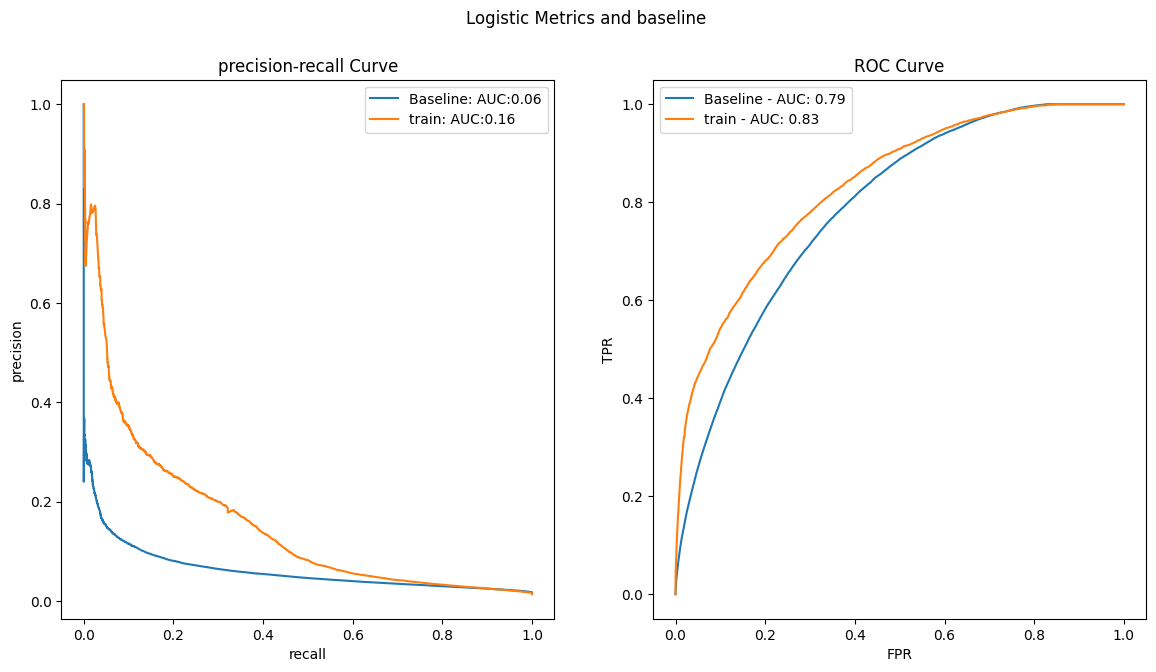

In [15]:
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Logistic Metrics and baseline")

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1)
)

y_test_proba_LogReg_model_rigde_f = LogReg_model_rigde_f.predict_proba(x_test_f)[:,1]
plot_metrics(
    f"train",y_pred=y_test_proba_LogReg_model_rigde_f,y_test=y_test,figure=(fig1,ax1)
)

# Random Forest

In [34]:
randomforest_model_dataset_trhee_variable=RandomForestClassifier(
    class_weight="balanced",
    #max_depth=None,
    n_jobs=-1,)

randomforest_model_dataset_normal=RandomForestClassifier(
    class_weight="balanced",
    #max_depth=None,
    n_jobs=-1,)

In [35]:
randomforest_model_dataset_trhee_variable = randomforest_model_dataset_trhee_variable.fit(x_train_f, y_train)
randomforest_model_dataset_normal =  randomforest_model_dataset_normal.fit(x_train, y_train)

In [ ]:
y_train_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict(x_train_f)
y_test_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict(x_test_f)

print(f"Report dataset three train:\n", classification_report(y_train, y_train_randomforest_model_trhee_variable))
print(f"Report dataset three test:\n", classification_report(y_test, y_test_randomforest_model_trhee_variable))

y_train_randomforest_model_normal = randomforest_model_dataset_normal.predict(x_train)
y_test_randomforest_model_normal = randomforest_model_dataset_normal.predict(x_test)

print(f"Report dataset complete train:\n", classification_report(y_train, y_train_randomforest_model_normal))
print(f"Report dataset complete test:\n", classification_report(y_test, y_test_randomforest_model_normal))


Report dataset three train:
               precision    recall  f1-score   support

         0.0       0.99      0.80      0.89   1492055
         1.0       0.05      0.72      0.10     22712

    accuracy                           0.80   1514767
   macro avg       0.52      0.76      0.49   1514767
weighted avg       0.98      0.80      0.88   1514767

Report dataset three test:
               precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    426947
         1.0       0.02      0.16      0.03      5843

    accuracy                           0.87    432790
   macro avg       0.50      0.52      0.48    432790
weighted avg       0.97      0.87      0.92    432790

Report dataset complete train:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99   1492055
         1.0       0.36      0.99      0.52     22712

    accuracy                           0.97   1514767
   macro avg       0.68      0.98      

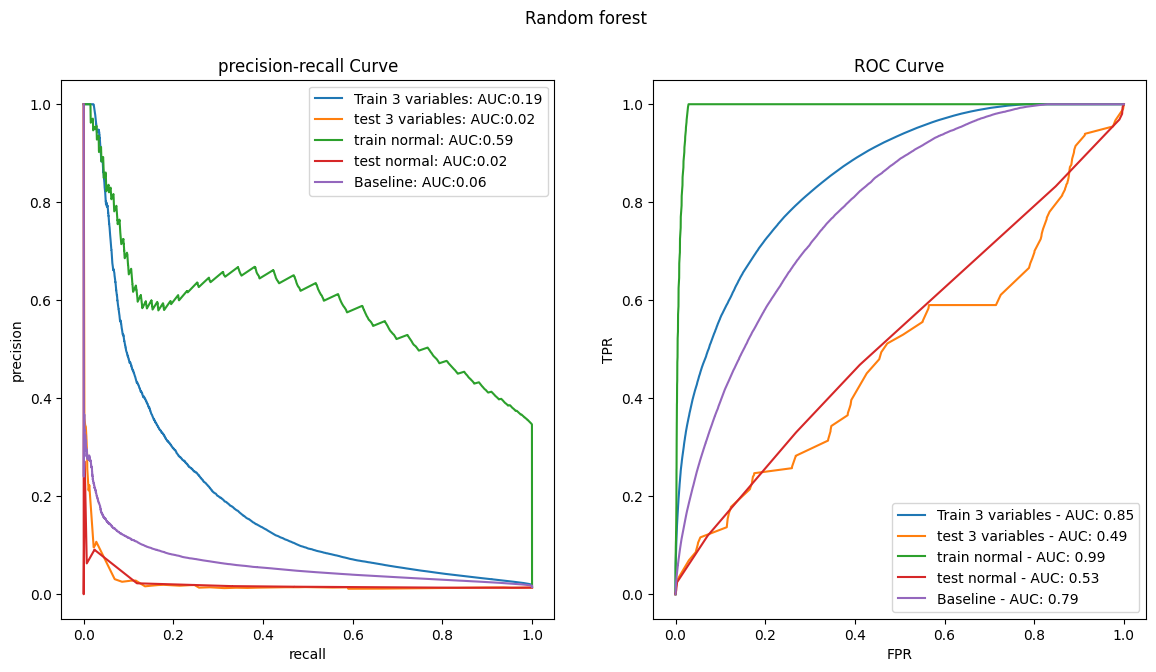

In [38]:
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Random forest")


y_train_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict_proba(x_train_f)[:,1]
plot_metrics(
    f"Train 3 variables",y_pred=y_train_randomforest_model_trhee_variable,y_test=y_train,figure=(fig1,ax1)
)

y_test_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict_proba(x_test_f)[:,1]
plot_metrics(
    f"test 3 variables",y_pred=y_test_randomforest_model_trhee_variable,y_test=y_test,figure=(fig1,ax1)
)

y_train_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(x_train)[:,1]
plot_metrics(
    f"train normal",y_pred=y_train_randomforest_model_normal,y_test=y_train,figure=(fig1,ax1)
)

y_test_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(x_test)[:,1]
plot_metrics(
    f"test normal",y_pred=y_test_randomforest_model_normal,y_test=y_test,figure=(fig1,ax1)
)

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1)
)

modifity the max depth = 5

In [39]:
randomforest_model_dataset_trhee_variable=RandomForestClassifier(
    class_weight="balanced",
    max_depth=2,
    n_jobs=-1,)

randomforest_model_dataset_normal=RandomForestClassifier(
    class_weight="balanced",
    max_depth=5,
    n_jobs=-1,)

In [40]:
randomforest_model_dataset_trhee_variable = randomforest_model_dataset_trhee_variable.fit(x_train_f, y_train)
randomforest_model_dataset_normal =  randomforest_model_dataset_normal.fit(x_train, y_train)

In [41]:
y_train_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict(x_train_f)
y_test_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict(x_test_f)

print(f"Report dataset three train:\n", classification_report(y_train, y_train_randomforest_model_trhee_variable))
print(f"Report dataset three test:\n", classification_report(y_test, y_test_randomforest_model_trhee_variable))

y_train_randomforest_model_normal = randomforest_model_dataset_normal.predict(x_train)
y_test_randomforest_model_normal = randomforest_model_dataset_normal.predict(x_test)

print(f"Report dataset complete train:\n", classification_report(y_train, y_train_randomforest_model_normal))
print(f"Report dataset complete test:\n", classification_report(y_test, y_test_randomforest_model_normal))


Report dataset three train:
               precision    recall  f1-score   support

         0.0       1.00      0.62      0.77   1492055
         1.0       0.03      0.84      0.06     22712

    accuracy                           0.62   1514767
   macro avg       0.51      0.73      0.41   1514767
weighted avg       0.98      0.62      0.75   1514767

Report dataset three test:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    426947
         1.0       0.01      1.00      0.03      5843

    accuracy                           0.01    432790
   macro avg       0.01      0.50      0.01    432790
weighted avg       0.00      0.01      0.00    432790

Report dataset complete train:
               precision    recall  f1-score   support

         0.0       1.00      0.66      0.80   1492055
         1.0       0.04      0.82      0.07     22712

    accuracy                           0.67   1514767
   macro avg       0.52      0.74      

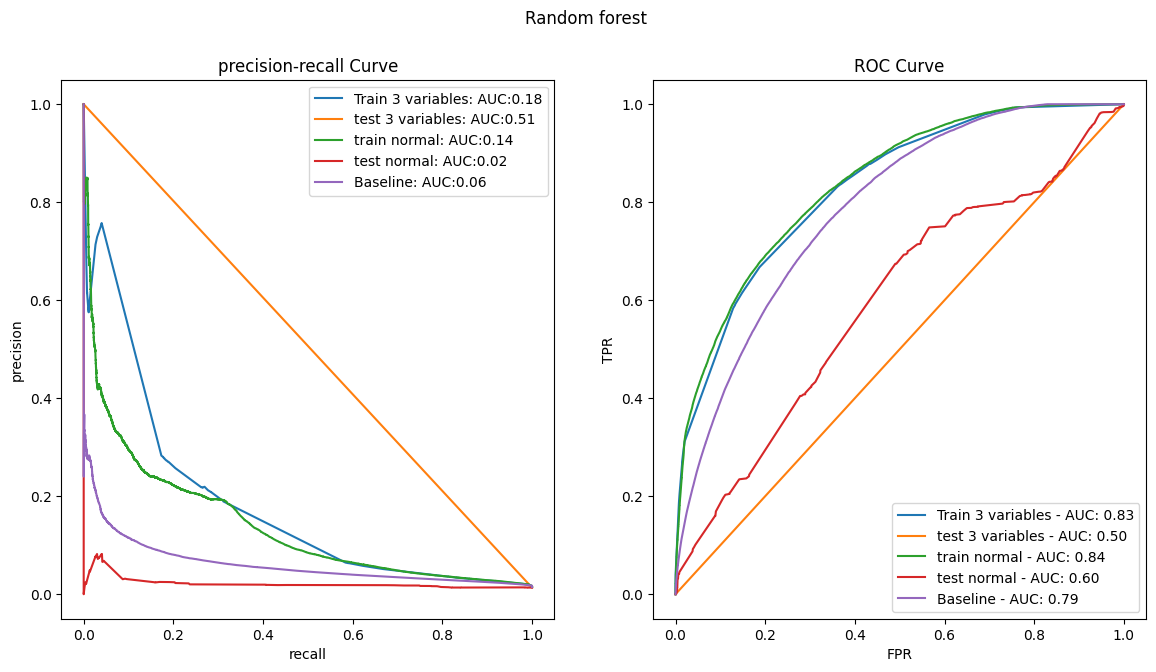

In [42]:
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Random forest")


y_train_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict_proba(x_train_f)[:,1]
plot_metrics(
    f"Train 3 variables",y_pred=y_train_randomforest_model_trhee_variable,y_test=y_train,figure=(fig1,ax1)
)

y_test_randomforest_model_trhee_variable = randomforest_model_dataset_trhee_variable.predict_proba(x_test_f)[:,1]
plot_metrics(
    f"test 3 variables",y_pred=y_test_randomforest_model_trhee_variable,y_test=y_test,figure=(fig1,ax1)
)

y_train_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(x_train)[:,1]
plot_metrics(
    f"train normal",y_pred=y_train_randomforest_model_normal,y_test=y_train,figure=(fig1,ax1)
)

y_test_randomforest_model_normal = randomforest_model_dataset_normal.predict_proba(x_test)[:,1]
plot_metrics(
    f"test normal",y_pred=y_test_randomforest_model_normal,y_test=y_test,figure=(fig1,ax1)
)

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1))